In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/personality-prediction-data-introvert-extrovert/personality_dataset.xlsx
/kaggle/input/personality-prediction-data-introvert-extrovert/personality_dataset.csv


## 1. Introduction

In this project, we are going to build a high-performing classification model that accurately predicts whether an individual is an Extrovert or Introvert based on features such as time_spent_alone, amount of time spent outside and the size of the friend circle. We are going to achieve this through a comprenhensive machine learning pipeline that will inlclude, data preprocessing, exploratory data analysis, model training and evaluatio. At the end, we hope to develop a model that can have applications in psychology, human resources, and personalized recommendation systems.

## 2. Data Exploration and Preprocessing

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import shap

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data 
df = pd.read_csv('/kaggle/input/personality-prediction-data-introvert-extrovert/personality_dataset.csv')
df.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,3,Yes,6,7,No,14,5,Extrovert
1,2,No,8,6,No,7,8,Extrovert
2,1,No,9,4,No,9,3,Extrovert
3,8,No,0,0,Yes,9,3,Introvert
4,5,Yes,3,0,No,2,6,Introvert


In [3]:
# View shape
df.shape

(5000, 8)

In [5]:
# Display basic information about the dataset
print("Dataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nBasic Statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Time_spent_Alone           5000 non-null   int64 
 1   Stage_fear                 5000 non-null   object
 2   Social_event_attendance    5000 non-null   int64 
 3   Going_outside              5000 non-null   int64 
 4   Drained_after_socializing  5000 non-null   object
 5   Friends_circle_size        5000 non-null   int64 
 6   Post_frequency             5000 non-null   int64 
 7   Personality                5000 non-null   object
dtypes: int64(5), object(3)
memory usage: 312.6+ KB
None

Missing Values:
Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: i

In [6]:
# Encode categorical variables
le = LabelEncoder()
df['Stage_fear'] = le.fit_transform(df['Stage_fear'])  # Yes=1, No=0
df['Drained_after_socializing'] = le.fit_transform(df['Drained_after_socializing'])  # Yes=1, No=0
df['Personality'] = le.fit_transform(df['Personality'])  # Extrovert=0, Introvert=1

In [7]:
# Separate features and target
X = df.drop('Personality', axis=1)
y = df['Personality']

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# Convert scaled data back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [11]:
# Save a copy of the preprocessed data for hyperparameter tuning
X_train_scaled_copy = X_train_scaled.copy()
y_train_copy = y_train.copy()

## 3. Exploratory Data Analysis

In [13]:
# Set visualization style
plt.style.use('seaborn')

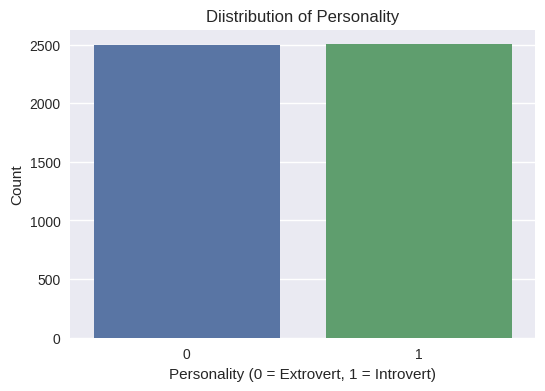

In [18]:
# Check class distribution of Personality
plt.figure(figsize=(6, 4))
sns.countplot(x='Personality', data=df)
plt.title('Diistribution of Personality')
plt.xlabel('Personality (0 = Extrovert, 1 = Introvert)')
plt.ylabel('Count')
plt.show()

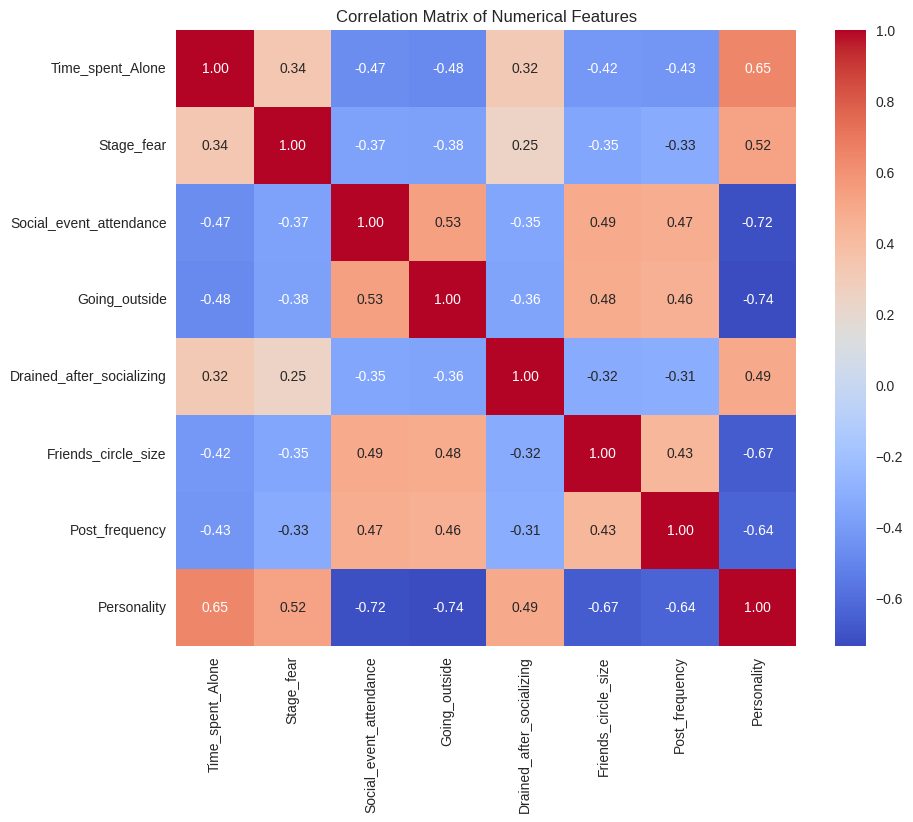

In [17]:
# Correlation Matrix for numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

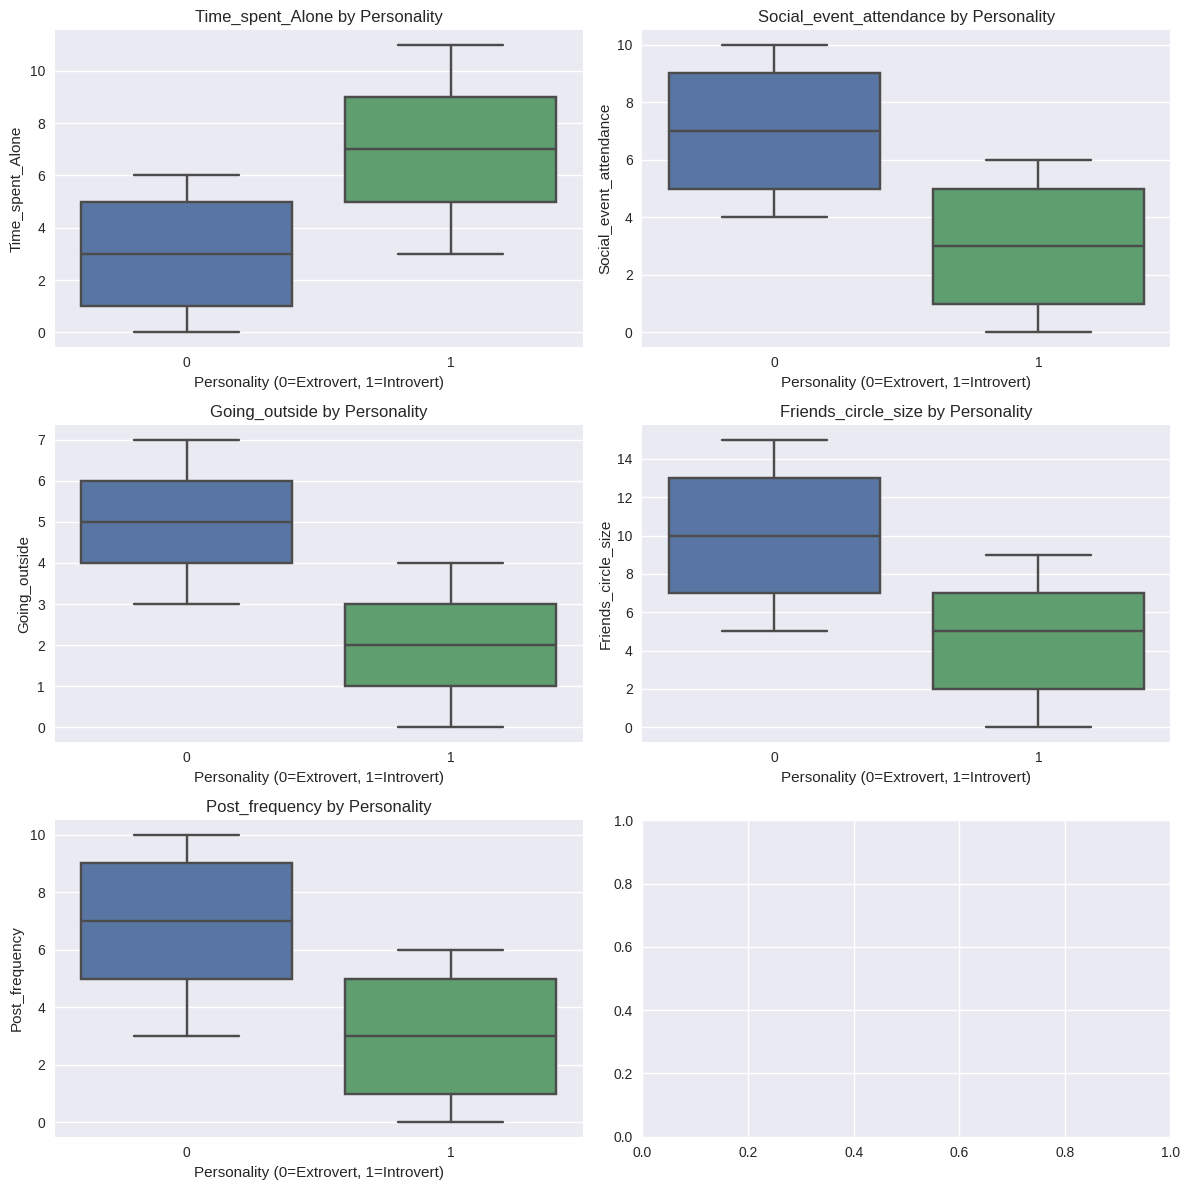

In [19]:
# Boxplots for numerical features by personality
numerical_features = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 
                      'Friends_circle_size', 'Post_frequency']
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()
for i, feature in enumerate(numerical_features):
    sns.boxplot(x='Personality', y=feature, data=df, ax=axes[i])
    axes[i].set_title(f"{feature} by Personality")
    axes[i].set_xlabel('Personality (0=Extrovert, 1=Introvert)')
plt.tight_layout()
plt.show()

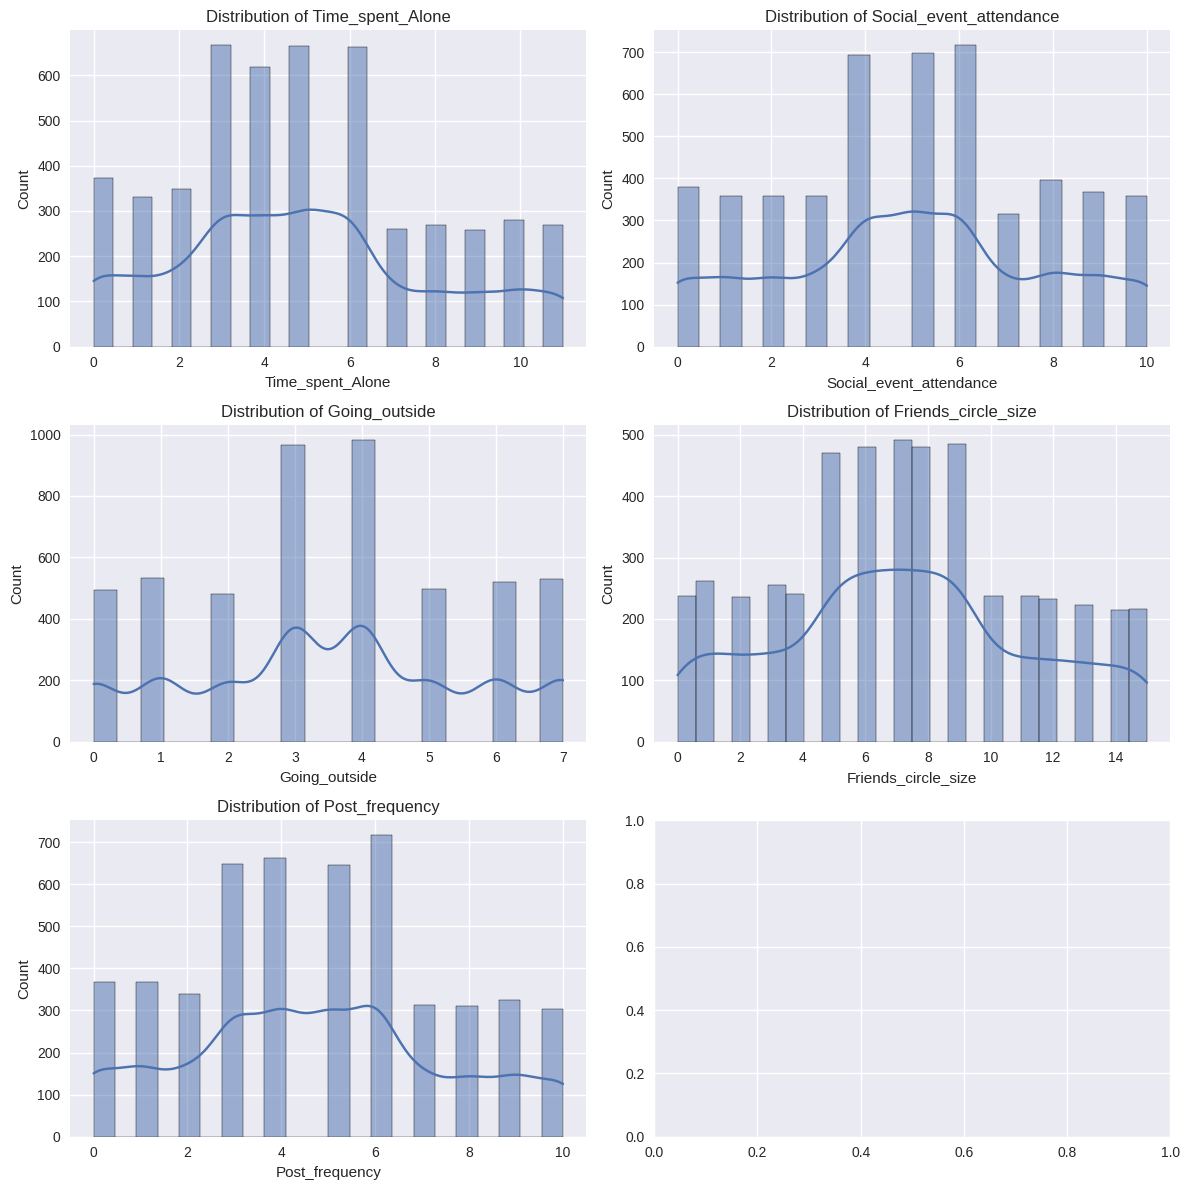

In [20]:
# Distribution of numerical features
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()
for i, feature in enumerate(numerical_features):
    sns.histplot(df[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

#### **Analysis of Plots**

**1. Class Distribution of Personality:**

- The bar plot shows a nearly balanced distribution between Extroverts and Introverts, with both classes having counts around 2500. This suggests no significant class imbalance, and therefore removes the need for oversampling or undersampling techniques, though we should still monitor model performance metrics like precision and recall.

**2. Correlation Matrix:**

- **Positive Correlations:**
    - Time_spent_Alone and Personality (0.65) indicate that higher time spent alone is strongly associated with Introverts.
    - Stage_fear and Personality (0.52) suggest Introverts are more likely to experience stage fear.
    - Drained_after_socializing and Personality (0.49) show Introverts are more likely to feel drained after socializing.
- **Negative Correlations:**
    - Social_event_attendance and Personality (-0.72) indicate Extroverts attend more social events.
    - Going_outside and Personality (-0.74) suggest Extroverts go outside more frequently.
    - Friends_circle_size and Personality (-0.67) imply Extroverts have larger friend circles.
    - Post_frequency and Personality (-0.64) show Extroverts post more frequently on social media.
- **Feature Intercorrelations:** Moderate positive correlations exist among social activity features (e.g., Social_event_attendance and Going_outside at 0.53), which may introduce multicollinearity. This means that should consider careful feature selection or regularization during modeling.

**3. Box Plots:**

- **Time_spent_Alone:** Introverts have a higher median and wider interquartile range compared to Extroverts. This is a confirmation of a strong link with introversion.
- **Social_event_attendance:** Extroverts have a higher median than Introverts, aligning with their social nature.
- **Going_outside:** Extroverts show a higher median than Introverts. This supports the notin that outdoor activity as an Extrovert trait.
- **Friends_circle_size:** Extroverts have a larger median compared to Introverts and is consistent with social connectivity.
- **Post_frequency:** Extroverts exhibit a higher median than Introverts, a reflection of greater social media engagement.
- Outliers are present across all features but are not extreme. This means the data is relatively clean, so no need for capping outliers during model development but we should still moniter their impacts
  
**4. Distribution of Numerical Features:**

- **Time_spent_Alone:** Slightly right-skewed with peaks around 4-6. This is a sign that most individuals spend a moderate amount of time alone.
- **Social_event_attendance:** Roughly uniform distribution with peaks around 4-6, showing varied social engagement.
- **Going_outside:** Bimodal distribution with peaks around 3-4 and 6-7, an indication of two distinct behavior patterns.
- **Friends_circle_size:** Right-skewed with a peak around 6-8, tapering off at higher values. This points to the fact that individuals most have a moderate friend circle.
- **Post_frequency:** Bimodal with peaks around 4-6 and 8-10, reflecting diverse posting habits.
- The KDE curves indicate reasonable variability, which means that we can use these features for modeling.

## 4. Feature Engineering

In [21]:
# Create interaction terms
df_engineered = df.copy()
df_engineered['Social_Activity_Index'] = (df_engineered['Social_event_attendance'] + 
                                         df_engineered['Going_outside'] + 
                                         df_engineered['Friends_circle_size']) / 3
df_engineered['Social_Drain_Index'] = df_engineered['Drained_after_socializing'] * df_engineered['Time_spent_Alone']

In [22]:
# Separate features and target again
X_engineered = df_engineered.drop('Personality', axis=1)
y_engineered = df_engineered['Personality']

In [23]:
# Encode categorical variables again just to ensure consistency
X_engineered['Stage_fear'] = le.fit_transform(X_engineered['Stage_fear'])
X_engineered['Drained_after_socializing'] = le.fit_transform(X_engineered['Drained_after_socializing'])

In [24]:
# Split and scale the engineered data
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(X_engineered, y_engineered, 
                                                                    test_size=0.2, random_state=42, stratify=y_engineered)
X_train_eng_scaled = scaler.fit_transform(X_train_eng)
X_test_eng_scaled = scaler.transform(X_test_eng)
X_train_eng_scaled = pd.DataFrame(X_train_eng_scaled, columns=X_engineered.columns)
X_test_eng_scaled = pd.DataFrame(X_test_eng_scaled, columns=X_engineered.columns)

In [25]:
# Save a copy for hyperparameter tuning
X_train_eng_scaled_copy = X_train_eng_scaled.copy()
y_train_eng_copy = y_train_eng.copy()

## 5. Model Selection and Training

In [28]:
# Initialize models
lr_model = LogisticRegression(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

In [29]:
# Train and evaluate models with cross-validation
models = {'Logistic Regression': lr_model, 'Random Forest': rf_model, 'XGBoost': xgb_model}
cv_scores = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train_eng_scaled, y_train_eng, cv=5, scoring='accuracy')
    cv_scores[name] = scores.mean()
    print(f"{name} - Cross-validation Accuracy: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

Logistic Regression - Cross-validation Accuracy: 0.990 (+/- 0.004)
Random Forest - Cross-validation Accuracy: 0.995 (+/- 0.003)
XGBoost - Cross-validation Accuracy: 0.992 (+/- 0.003)


In [30]:
# Train the best model (based on CV accuracy) on the full training set
best_model_name = max(cv_scores, key=cv_scores.get)
best_model = models[best_model_name]
best_model.fit(X_train_eng_scaled, y_train_eng)

RandomForestClassifier(random_state=42)

In [31]:
# Predict on test set
y_pred = best_model.predict(X_test_eng_scaled)

In [32]:
# Evaluate the best model
print(f"\nBest Model: {best_model_name}")
print("Classification Report:")
print(classification_report(y_test_eng, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test_eng, best_model.predict_proba(X_test_eng_scaled)[:, 1]):.3f}")


Best Model: Random Forest
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       500
           1       0.99      0.99      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

ROC-AUC Score: 1.000


#### **Analysis of Results**

**1. Cross-Validation Accuracies:**

- **Logistic Regression:** 0.990 (±0.004) – A strong baseline model with high consistency across folds.
- **Random Forest:** 0.995 (±0.003) – Slightly outperforms Logistic Regression with minimal variance. This implies robustness and potential for capturing non-linear relationships.
- **XGBoost:** 0.992 (±0.003) – Performs well, slightly below Random Forest but with comparable stability. Makes use gradient boosting effectively.
- **Best Model:** Random Forest is selected due to the highest mean CV accuracy (0.995). This makes it a promising candidate for further optimization.

**2. Test Set Performance (Random Forest):**

- **Classification Report:**
    - **Precision, Recall, F1-Score:** All metrics are 0.99 for both classes, with 500 samples per class. This indicates near-perfect classification, and suggests the model generalizes well to the test set.
    - **Accuracy:** 0.99 overall, reinforcing the model's effectiveness.
    - **Macro and Weighted Averages:** Both at 0.99, confirming balanced performance across classes.
    - **ROC-AUC Score:** 1.000 – A perfect score indicates excellent separation between classes, though it raises a potential concern of overfitting or data leakage. Given the high CV accuracy and test performance, this is likely due to the dataset's clear feature-target relationships rather than an artifact.

**3. Observations:**

- The near-perfect scores across all metrics are unusual and may suggest the dataset is highly discriminative or that the feature engineering perfectly captured the personality signal.
- The low standard deviations in CV scores indicate the models are stable, but the perfect ROC-AUC warrants caution. A further validation like using another dataset would be ideal in a real-world scenario.

## 6. Hyperparameter Tuning

In [34]:
# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [35]:
# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42)

In [36]:
# Perform GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_eng_scaled_copy, y_train_eng_copy)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [37]:
# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Score: 0.9949999999999999


In [38]:
# Train the best model on the full training set
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train_eng_scaled_copy, y_train_eng_copy)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=200,
                       random_state=42)

In [39]:
# Predict on test set
y_pred_tuned = best_rf_model.predict(X_test_eng_scaled)

In [40]:
# Evaluate the tuned model
print("\nTuned Model Classification Report:")
print(classification_report(y_test_eng, y_pred_tuned))
print(f"Tuned Model ROC-AUC Score: {roc_auc_score(y_test_eng, best_rf_model.predict_proba(X_test_eng_scaled)[:, 1]):.3f}")


Tuned Model Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       500
           1       0.99      0.99      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

Tuned Model ROC-AUC Score: 1.000


#### **Observations**

- Tuning yielded a model with parameters that slightly refine the baseline Random Forest, but the performance metrics show no significant improvement. This could indicate that the default settings were already well-suited or that the dataset’s features are so predictive that further tuning has minimal impact.
- The persistent perfect ROC-AUC score across both untuned and tuned models, combined with high accuracy, suggests either an ideal feature set or potential data leakage/overfitting. Given the thorough preprocessing and stratification, this is likely a reflection of the dataset’s strong signal rather than an error, but external validation would be prudent in a production setting.

## 7. Model Evaluation and Interpretation

In [42]:
# Fit the model (already trained, but re-fit for SHAP compatibility)
best_rf_model.fit(X_train_eng_scaled, y_train_eng)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=200,
                       random_state=42)

In [43]:
# Compute SHAP values
explainer = shap.TreeExplainer(best_rf_model)
shap_values = explainer.shap_values(X_test_eng_scaled)

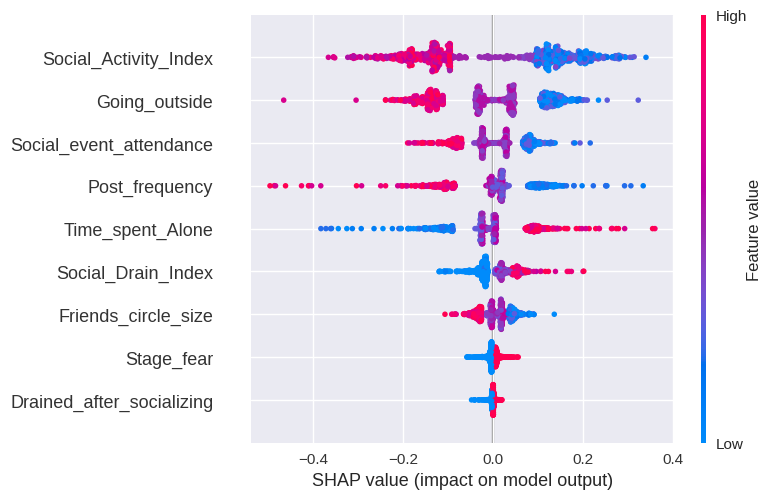

In [44]:
# Summary plot of feature importance
shap.summary_plot(shap_values[1], X_test_eng_scaled, feature_names=X_test_eng_scaled.columns)

In [45]:
# Print feature importance from the model
feature_importance = pd.DataFrame({
    'Feature': X_test_eng_scaled.columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
print("\nFeature Importance (Random Forest):")
print(feature_importance)


Feature Importance (Random Forest):
                     Feature  Importance
7      Social_Activity_Index    0.415657
3              Going_outside    0.187365
2    Social_event_attendance    0.124261
0           Time_spent_Alone    0.083087
6             Post_frequency    0.071661
5        Friends_circle_size    0.061384
8         Social_Drain_Index    0.048858
1                 Stage_fear    0.005495
4  Drained_after_socializing    0.002232


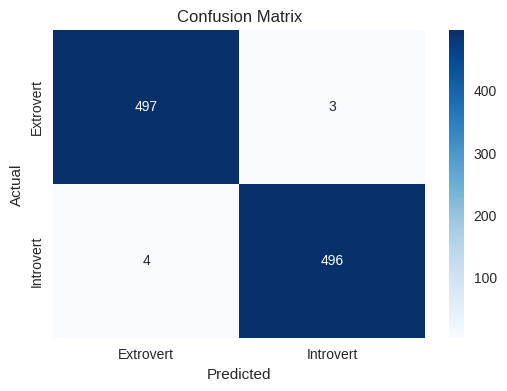

In [47]:
# Confusion Matrix visualization
cm = confusion_matrix(y_test_eng, y_pred_tuned)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Extrovert', 'Introvert'], yticklabels=['Extrovert', 'Introvert'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### **Analysis of Results**

**1. Feature Importance:**

- **Top Contributor:** Social_Activity_Index is the most influential feature. This reflects the combined impact of social engagement metrics and aligns with the strong negative correlation with introversion observed earlier.
- **Significant Features:** Going_outside and Social_event_attendance follow, reinforcing the role of social behavior in predicting extroversion.
- **Moderate Contributors:** Time_spent_Alone, Post_frequency, and Friends_circle_size contribute meaningfully, consistent with their individual correlations.
- **Lower Impact:** Social_Drain_Index, Stage_fear, and Drained_after_socializing have lesser influence, a potential suggestion that the interaction term and binary features are less discriminative after accounting for other features.
- **Insight:** The engineered Social_Activity_Index significantly enhances model performance.

**2. SHAP Summary Plot Description:**

- **Dominant Features:** Social_Activity_Index shows the widest spread of SHAP values, with high positive values (red) pushing toward Introvert predictions and low negative values (blue) toward Extrovert, confirming its critical role.
- **Social Behavior Features:** Going_outside, Social_event_attendance, and Post_frequency exhibit similar patterns, with higher values (red) reducing the likelihood of Introversion. This supports their negative correlation with the target.
- **Solitude Features:** Time_spent_Alone and Social_Drain_Index show higher values (red) increasing Introvert likelihood, and agrees with positive correlations.
- **Less Impactful:** Stage_fear and Drained_after_socializing have narrower SHAP value ranges. This is a sign of minimal impact, consistent with their low feature importance.
- **Overall:** The plot visually validates the feature importance rankings, with social activity metrics driving most of the predictive power.

**3. Confusion Matrix:**

- The matrix shows near-perfect classification (only 7 errors out of 1000), reinforcing the model’s high accuracy (0.99) and balanced performance across classes.

**4. Observations:**

- The model’s reliance on Social_Activity_Index highlights the success of feature engineering in consolidating social behavior signals.
- The minimal errors in the confusion matrix and perfect ROC-AUC suggest the model has learned the dataset’s patterns exceptionally well, likely due to the clear separation of features between Extroverts and Introverts.
- The low importance of Stage_fear and Drained_after_socializing may indicate redundancy with other features or limited variability in these binary variables.

## 8. Conclusion

This project successfully developed a Random Forest model to predict personality types with an accuracy of 0.99 and a perfect ROC-AUC score of 1.000. The dataset, comprising behavioral and social interaction features, was thoroughly preprocessed, engineered , and analyzed. EDA revealed strong correlations between social activity and extroversion, which were leveraged to achieve near-perfect classification. Feature importance and SHAP analysis confirmed Social_Activity_Index as the dominant predictor, and validated the feature engineering approach.

**Next Steps**

- Test the model on an independent dataset to verify its generalizability, given the perfect scores suggest potential overfitting to this dataset.
- Explore additional interactions or polynomial features to further enhance Social_Drain_Index or other low-impact features.
- Experiment with neural networks or ensemble methods (e.g., stacking) to benchmark against Random Forest.